# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 16/02/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os
import concurrent.futures
import timeit

import matplotlib
%matplotlib widget

import h5py
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt


import ImageD11.columnfile
from ImageD11.sinograms import properties, roi_iradon
from ImageD11.blobcorrector import eiger_spatial
from ImageD11.grain import grain
from ImageD11 import cImageD11

import utils

In [3]:
# OLD DATASETS

# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA
# In this case, use this cell to specify where your experimental folder is, and do not run the cell below
# e.g /data/visitor/4752/id11/20210513

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ma4752/id11/20210618"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ma4752/id11/20240118/James"

total 5249
-rwxr-x---  1 backup backup 5372439 Jun 25  2021 ma4752_id11.h5
drwxr-x--- 25 backup backup    4096 Jan 18 06:08 MA4752_S4_2_XRD


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "MA4752_S4_2_XRD"
dataset = "DTL1z90"

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

par_path = 'nickel.par'

e2dx_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf"
e2dy_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"

In [6]:
# Load the dataset (for motor positions, not sure why these are not in peaks)
ds = ImageD11.sinograms.dataset.load(dset_path)

In [7]:
# Import 2D peaks

cf_2d = ImageD11.columnfile.columnfile(ds.col2dfile)

cf_2d.parameters.loadparameters(par_path)
cf_2d.updateGeometry()

print(f"Read {cf_2d.nrows} 2D peaks")

index_column = np.arange(cf_2d.nrows)
cf_2d.addcolumn(index_column, 'index')

Reading your columnfile in hdf format
Read 136932470 2D peaks


In [8]:
def read_grains(ds):
    with h5py.File(ds.grainsfile, 'r') as hin:
        grp = hin['slice_recon']
        
        raw_intensity_array = grp['intensity'][:]
        grain_labels_array = grp['labels'][:]
       
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            g = ImageD11.grain.grain(ubi)
            # general grain properties
            g.gid = int(gid_string)
            g.translation = gg['translation'][:]
            g.cen = gg.attrs['cen']
            # sinogram stuff
            g.ssino = gg['ssino'][:]
            g.sinoangles = gg['sinoangles'][:]
            # reconstructions
            g.og_recon = gg['og_recon'][:]
            g.recon = gg['recon'][:]
            grains.append(g)
    
    return grains, raw_intensity_array, grain_labels_array

In [9]:
grains, raw_intensity_array, grain_labels_array = read_grains(ds)

  0%|          | 0/45 [00:00<?, ?it/s]

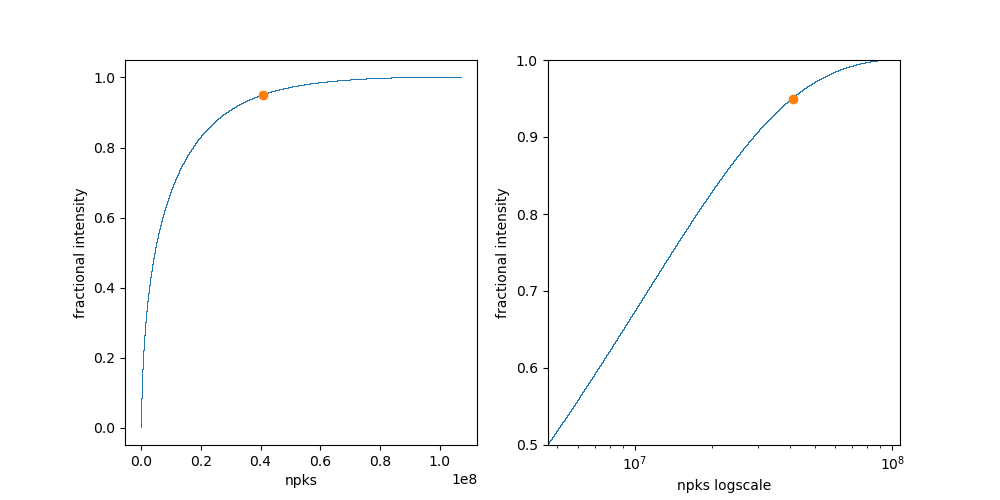

136932470
40985930


In [10]:
# filter 2D peaks by intensity

cf_2d_strong = utils.selectpeaks(cf_2d, frac=0.95, dsmax=cf_2d.ds.max(), doplot=0.5)
print(cf_2d.nrows)
print(cf_2d_strong.nrows)

In [11]:
cf_2d_strong.addcolumn(np.cos(np.radians(cf_2d_strong.omega)), 'cosomega')
cf_2d_strong.addcolumn(np.sin(np.radians(cf_2d_strong.omega)), 'sinomega')

In [12]:
tol = 0.025

# column to store the grain labels
labels_2d_strong = np.zeros(cf_2d_strong.nrows, 'i')
# get all g-vectors from columnfile
gvecs_2d_strong = np.transpose((cf_2d_strong.gx, cf_2d_strong.gy, cf_2d_strong.gz)).astype(float)
# column to store drlv2 (error in hkl)
drlv2_strong = np.ones(cf_2d_strong.nrows, 'd')
# iterate over all grains
print(f"Scoring and assigning {len(grains)} grains")
for g in tqdm(grains):
    n = ImageD11.cImageD11.score_and_assign(g.ubi, gvecs_2d_strong, tol, drlv2_strong, labels_2d_strong, g.gid)

# add the labels column to the columnfile
cf_2d_strong.addcolumn(labels_2d_strong, 'grain_id')

print("Storing peak data in grains")
# iterate through all the grains

# make lookup table for grain IDs so we can quickly get the grain given a GID (might not be contiguous or start at 0)
grain_lut = {}
for g in tqdm(grains):
    grain_lut[g.gid] = g
    g.mask_2d_strong = cf_2d_strong.grain_id == g.gid
    
    g.gve_2d_strong = gvecs_2d_strong[g.mask_2d_strong].T
    
    g.cosomega = cf_2d_strong.cosomega[g.mask_2d_strong]
    g.sinomega = cf_2d_strong.sinomega[g.mask_2d_strong]
    
    g.dty = cf_2d_strong.dty[g.mask_2d_strong]


Scoring and assigning 45 grains


  0%|          | 0/45 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/45 [00:00<?, ?it/s]

In [13]:
for grain in grains:
    grain.label_mask = grain_labels_array == grain.gid

In [14]:
# refine each grain's ubi using all contributory pixels
# use the tolerance we used for assignment earlier

for grain in tqdm(grains):

    ubifit = grain.ubi.copy()
    _ = cImageD11.score_and_refine(ubifit, np.transpose(grain.gve_2d_strong), tol)
    
    grain.set_ubi(ubifit)

  0%|          | 0/45 [00:00<?, ?it/s]

In [15]:
# WORKING

# for each grain
# for each pixel in the mask
# local refinement
# global container

n_ysteps_tol = 10
# y0 = 16.04656032771845/2
y0 = 1.25

per_pixel_ubis = {}

nthreads = len(os.sched_getaffinity(os.getpid()))

for ginc, grain in enumerate(tqdm(grains[:])):
    def refine_ubis(pixel_position):
        i, j = pixel_position
        
        # convert pixel position to real space micron position
        
        a = (j - grains[0].recon.shape[0]//2) * ds.ystep
        b = (i - grains[0].recon.shape[0]//2) * ds.ystep
        
        dty_calc = a*grain.cosomega - b*grain.sinomega + y0  # microns
        
        mask = np.abs(grain.dty - dty_calc) < n_ysteps_tol*ds.ystep
        
        gve = np.transpose(grain.gve_2d_strong[:, mask])
        
        ubifit = grain.ubi.copy()
        _ = cImageD11.score_and_refine(ubifit, gve, tol)

        return ubifit

    pixel_positions = np.argwhere(grain.label_mask == True)
    
    with concurrent.futures.ThreadPoolExecutor(max_workers = max(1, nthreads-1)) as pool:
        pixel_ubis = pool.map(refine_ubis, pixel_positions)

    for pixel_position, ubi in zip(pixel_positions, pixel_ubis):
        per_pixel_ubis[tuple(pixel_position)] = (ginc, ubi)

  0%|          | 0/45 [00:00<?, ?it/s]

In [16]:
# write to file
# a UBI per pixel

ubi_map = np.empty((grains[0].recon.shape + (3,3)))
ubi_map.fill(np.nan)
for pxi in tqdm(range(grains[0].recon.shape[0])):
    for pxj in range(grains[0].recon.shape[1]):
        try:
            graininc, this_ubi = per_pixel_ubis[pxi, pxj]
            ubi_map[pxi, pxj, :, :] = this_ubi
        except KeyError:
            continue

  0%|          | 0/1060 [00:00<?, ?it/s]

In [17]:
pixel_grain_lut = {}
for i in tqdm(range(grains[0].recon.shape[0])):
    for j in range(grains[0].recon.shape[1]):
        this_ubi = ubi_map[i, j]
        if not np.isnan(this_ubi[0,0]):
            this_grain = ImageD11.grain.grain(this_ubi)
            pixel_grain_lut[i, j] = this_grain

  0%|          | 0/1060 [00:00<?, ?it/s]

In [18]:
eps_map = np.empty((grains[0].recon.shape + (3,3)))
eps_map.fill(np.nan)
for i in tqdm(range(grains[0].recon.shape[0])):
    for j in range(grains[0].recon.shape[1]):
        try:
            this_grain = pixel_grain_lut[i, j]
            this_ref_gid = grain_labels_array[i, j]
            this_ref_grain = grain_lut[this_ref_gid]
            this_eps = this_grain.eps_sample_matrix(dzero_cell=this_ref_grain.unitcell)
            eps_map[i, j] = this_eps
        except KeyError:
            continue

  0%|          | 0/1060 [00:00<?, ?it/s]

In [19]:
from xfab.symmetry import Umis

misorientation_map = np.empty((grains[0].recon.shape))
misorientation_map.fill(np.nan)
for i in tqdm(range(grains[0].recon.shape[0])):
    for j in range(grains[0].recon.shape[1]):
        try:
            this_grain = pixel_grain_lut[i, j]
            this_ref_gid = grain_labels_array[i, j]
            this_ref_grain = grain_lut[this_ref_gid]
            this_misorien = np.min(Umis(this_ref_grain.U, this_grain.U, 7), axis=0)[1]
            misorientation_map[i, j] = this_misorien
        except KeyError:
            continue

  0%|          | 0/1060 [00:00<?, ?it/s]

In [20]:
ipf_z_col_map = np.empty((grains[0].recon.shape + (3,)))
ipf_z_col_map.fill(np.nan)
for i in tqdm(range(grains[0].recon.shape[0])):
    for j in range(grains[0].recon.shape[1]):
        try:
            this_grain = pixel_grain_lut[i, j]
            this_ipf_z_col = utils.hkl_to_color_cubic(utils.crystal_direction_cubic(this_grain.ubi, (0, 0, 1)))
            ipf_z_col_map[i, j] = this_ipf_z_col
        except KeyError:
            continue

  0%|          | 0/1060 [00:00<?, ?it/s]

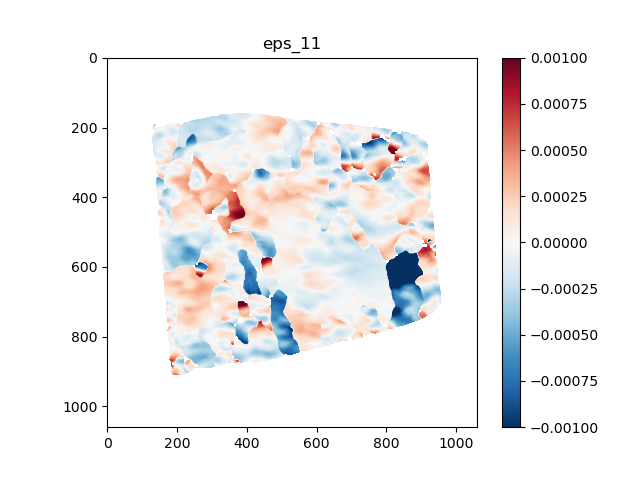

In [21]:
eps_s_11_map = eps_map[:, :, 0, 0]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_11_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
plt.colorbar(im)
ax.set_title("eps_11")
plt.show()

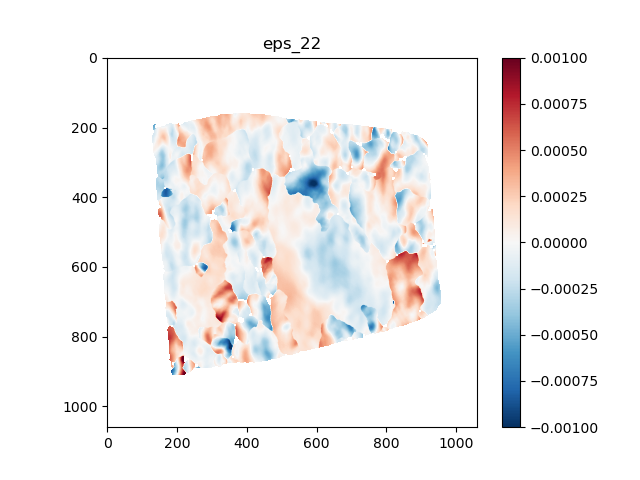

In [22]:
eps_s_22_map = eps_map[:, :, 1, 1]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_22_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
plt.colorbar(im)
ax.set_title("eps_22")
plt.show()

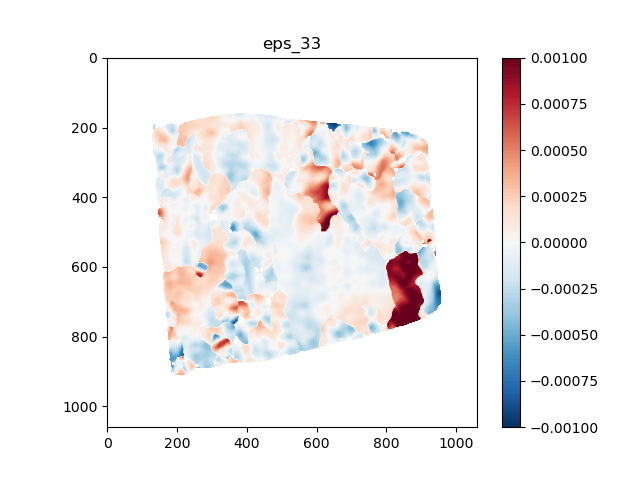

In [23]:
eps_s_33_map = eps_map[:, :, 2, 2]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_33_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
plt.colorbar(im)
ax.set_title("eps_33")
plt.show()

# add quivers!!!

/cvmfs/hpc.esrf.fr/software/packages/linux/x86_64/jupyter-slurm/2023.10.3/envs/jupyter-slurm/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


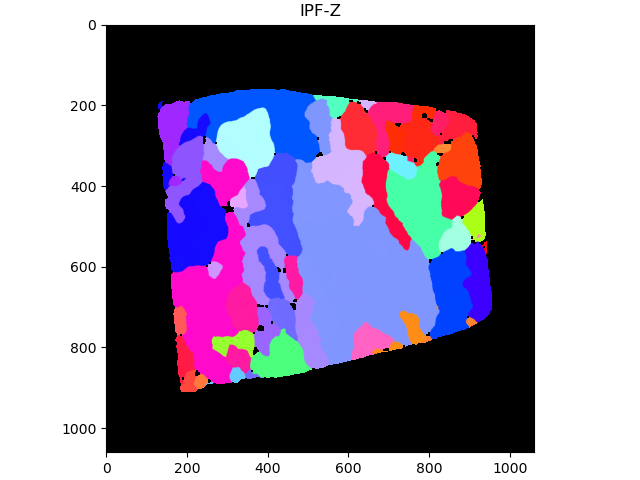

In [24]:
image_to_show = np.transpose((ipf_z_col_map[:, :, 0], ipf_z_col_map[:, :, 1], ipf_z_col_map[:, :, 2]), axes=(1, 2, 0))
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image_to_show)  # originally 1,2,0
ax.set_title("IPF-Z")
plt.show()

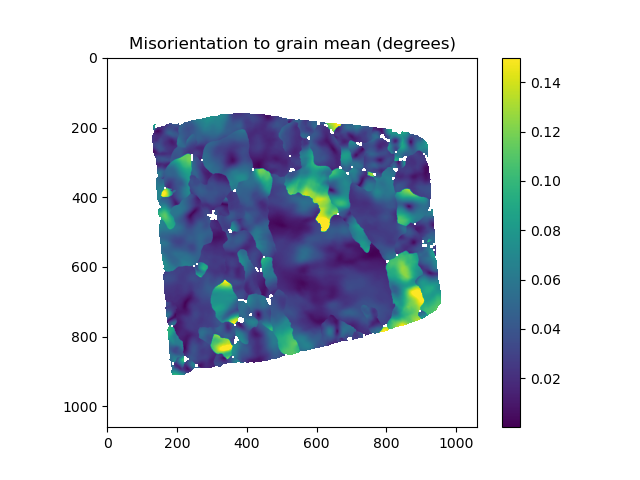

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(misorientation_map, vmax=0.15)
plt.colorbar(im)
ax.set_title("Misorientation to grain mean (degrees)")
plt.show()

In [28]:
ds.pbpubifile = os.path.join(ds.analysispath, ds.dsname + '_pbp_map.h5')

In [29]:
# save recons and 2d properties to existing grain file

cmp = {'compression':'gzip',
       'compression_opts': 2,
       'shuffle' : True }

def save_array(grp, name, ary):
    hds = grp.require_dataset(name, 
                              shape=ary.shape,
                              dtype=ary.dtype,
                              **cmp)
    hds[:] = ary
    return hds

def save_ubi_map(ds):
    with h5py.File(ds.pbpubifile, 'w') as hout:
        grp = hout.create_group('arrays')
        save_array(grp, 'ubi_map', ubi_map).attrs['description'] = 'Refined UBI values at each pixel'
        save_array(grp, 'eps_map', eps_map).attrs['description'] = 'Strain matrices (sample ref) at each pixel'
        save_array(grp, 'misorientation_map', misorientation_map).attrs['description'] = 'Misorientation to grain avg at each pixel'
        save_array(grp, 'ipf_z_col_map', ipf_z_col_map).attrs['description'] = 'IPF Z color at each pixel'

In [30]:
save_ubi_map(ds)